In [1]:
import re
import os
import gc
import json
import fiona
import shutil
import rasterio
import numpy as np
import pandas as pd
from tqdm import tqdm
import geopandas as gpd
from pathlib import Path
from osgeo import gdal, osr
import dask_geopandas as dgpd
from shapely.geometry import shape
from rasterstats import zonal_stats
import geopandas as gpd
import fiona

BASE_DIR = Path('/Users/wenlanzhang/PycharmProjects/Mapineq/src/data-wrangling/')
DATA_DIR = Path('/Users/wenlanzhang/Downloads/PhD_UCL/Data/Oxford')

# /Users/wenlanzhang/Downloads/PhD_UCL/Data/Oxford/ITL/2021

# 2021

<Axes: >

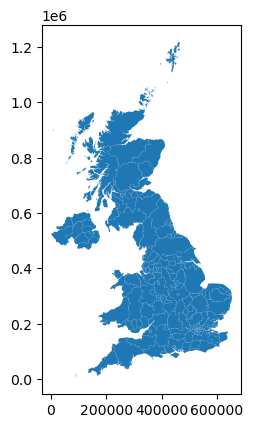

In [11]:
# Level 1
file_1 = DATA_DIR / 'ITL/2021/International_Territorial_Level_1_January_2021_UK_BFC_2022_-5765930388644519628.gpkg'
gdf_1 = gpd.read_file(file_1, layer=fiona.listlayers(file_1)[0])

# Level 2
file_2 = DATA_DIR / 'ITL/2021/International_Territorial_Level_2_January_2021_UK_BFC_V2_2022_5871547450835493961.gpkg'
gdf_2 = gpd.read_file(file_2, layer=fiona.listlayers(file_2)[0])

# Level 3
file_3 = DATA_DIR / 'ITL/2021/International_Territorial_Level_3_January_2021_UK_BFC_V3_2022_-8658942914266356245.gpkg'
gdf_3 = gpd.read_file(file_3, layer=fiona.listlayers(file_3)[0])
gdf_3.plot()

In [12]:
def standardize_itl_columns(gdf):
    # Find code and name columns dynamically
    code_col = [col for col in gdf.columns if col.startswith("ITL") and col.endswith("CD")]
    name_col = [col for col in gdf.columns if col.startswith("ITL") and col.endswith("NM")]

    if code_col and name_col:
        gdf = gdf.rename(columns={
            code_col[0]: "ITL_CODE",
            name_col[0]: "ITL_NAME"
        })
    else:
        print("⚠️ Could not find ITL code/name columns.")
    
    return gdf

gdf_1 = standardize_itl_columns(gdf_1)
gdf_2 = standardize_itl_columns(gdf_2)
gdf_3 = standardize_itl_columns(gdf_3)
gdf_1

,ITL_CODE,ITL_NAME,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry
0,TLC,North East (England),417314,600356,-1.728880,55.297009,{68F9064C-9694-4C7A-A96F-10246D341D99},"MULTIPOLYGON (((402076.296 506231.802, 402081...."
1,TLD,North West (England),350014,506279,-2.772390,54.449440,{46379CE8-0F02-434D-A104-C25B7A4794A7},"MULTIPOLYGON (((364516.901 338994.103, 364518...."
2,TLE,Yorkshire and The Humber,446902,448736,-1.287140,53.932640,{EDB4CBF2-F6E6-4731-9748-50DD354438B8},"MULTIPOLYGON (((450488.401 378555.099, 450507...."
3,TLF,East Midlands (England),477659,322635,-0.849690,52.795719,{E5D0FE59-D246-4748-926E-D03FD4BCEB28},"MULTIPOLYGON (((455193.701 231281.696, 455207...."
4,TLG,West Midlands (England),386294,295477,-2.203580,52.556969,{C8148E93-F036-4D66-91C4-B9B35171432D},"MULTIPOLYGON (((402840.498 368845.598, 402810...."
5,TLH,East,571078,263235,0.504207,52.240730,{29711A4D-C0E8-4467-90CE-4B8EE63CFF00},"MULTIPOLYGON (((564008.6 175098.15, 564012.9 1..."
6,TLI,London,517515,178392,-0.308660,51.492271,{08098926-B064-47F1-BCDE-5989A26EC08D},"MULTIPOLYGON (((530898.104 155850.797, 531112...."
7,TLJ,South East (England),470062,172924,-0.993110,51.450970,{7653168C-05D7-4593-A0BE-AA91BD335A81},"MULTIPOLYGON (((431612.298 89690.603, 431619.0..."
8,TLK,South West (England),285013,102567,-3.633460,50.811192,{78C0B029-043B-4F5D-8480-F06F810B04B8},"MULTIPOLYGON (((170406.03 11429.67, 170413.43 ..."
9,TLL,Wales,263405,242881,-3.994170,52.067410,{CB510AC9-5699-4B9E-BA6A-E221E6B281AE},"MULTIPOLYGON (((306677.016 165523.186, 306682...."


In [13]:
# Convert column names to sets (ignores order)
cols_1 = set(gdf_1.columns)
cols_2 = set(gdf_2.columns)
cols_3 = set(gdf_3.columns)

# Check pairwise equality
print("gdf_1 vs gdf_2:", cols_1 == cols_2)
print("gdf_2 vs gdf_3:", cols_2 == cols_3)
print("gdf_1 vs gdf_3:", cols_1 == cols_3)

print(f"ITL1: {len(gdf_1)} rows | ITL2: {len(gdf_2)} rows | ITL3: {len(gdf_3)} rows")

gdf_1 vs gdf_2: True
gdf_2 vs gdf_3: True
gdf_1 vs gdf_3: True
ITL1: 12 rows | ITL2: 41 rows | ITL3: 179 rows


In [5]:
# Combine them vertically
gdf_all = gpd.GeoDataFrame(
    pd.concat([gdf_1, gdf_2, gdf_3], ignore_index=True),
    crs=gdf_1.crs  # Assuming all share the same CRS
)
gdf_all

,ITL_CODE,ITL_NAME,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry
0,TLC,North East (England),417314,600356,-1.72888,55.297009,{68F9064C-9694-4C7A-A96F-10246D341D99},"MULTIPOLYGON (((402076.296 506231.802, 402081...."
1,TLD,North West (England),350014,506279,-2.77239,54.449440,{46379CE8-0F02-434D-A104-C25B7A4794A7},"MULTIPOLYGON (((364516.901 338994.103, 364518...."
2,TLE,Yorkshire and The Humber,446902,448736,-1.28714,53.932640,{EDB4CBF2-F6E6-4731-9748-50DD354438B8},"MULTIPOLYGON (((450488.401 378555.099, 450507...."
3,TLF,East Midlands (England),477659,322635,-0.84969,52.795719,{E5D0FE59-D246-4748-926E-D03FD4BCEB28},"MULTIPOLYGON (((455193.701 231281.696, 455207...."
4,TLG,West Midlands (England),386294,295477,-2.20358,52.556969,{C8148E93-F036-4D66-91C4-B9B35171432D},"MULTIPOLYGON (((402840.498 368845.598, 402810...."
...,...,...,...,...,...,...,...,...
227,TLN0E,Lisburn and Castlereagh,138776,518906,-6.03445,54.497429,{566D2F28-4343-4734-ABD1-7790293C7A7B},"MULTIPOLYGON (((138843.75 530937.408, 138842.7..."
228,TLN0F,Mid and East Antrim,134007,560141,-6.14545,54.864559,{A4521C0C-2AA2-491B-8581-8B388C0D49A0},"MULTIPOLYGON (((150795.129 539518.275, 150795...."
229,TLN0G,Fermanagh and Omagh,41284,512998,-7.52630,54.385109,{1A26282C-FDD6-433E-8F77-731B3CE6BC5D},"MULTIPOLYGON (((82437.33 553271.674, 82384.806..."
230,TLK24,"Bournemouth, Christchurch and Poole",410815,94066,-1.84807,50.746090,{98B1F5EC-DBEE-419B-A07B-341E86B40E47},"MULTIPOLYGON (((403849.666 87001.742, 403851.8..."


In [6]:
# Set output paths
output_dir = Path(DATA_DIR / 'ITL/2021/')
output_dir.mkdir(exist_ok=True)

shapefile_path = output_dir / "itl_2021.shp"

# Save GeoDataFrame to shapefile
gdf_all.to_file(shapefile_path)

# 2025

<Axes: >

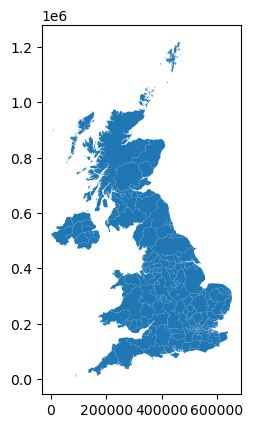

In [2]:
# Level 1
file_1 = DATA_DIR / 'ITL/2025/ITL1_JAN_2025_UK_BFC_6839916116953775332.gpkg'
gdf_1 = gpd.read_file(file_1, layer=fiona.listlayers(file_1)[0])

# Level 2
file_2 = DATA_DIR / 'ITL/2025/ITL2_JAN_2025_UK_BFC_8603024100172799104.gpkg'
gdf_2 = gpd.read_file(file_2, layer=fiona.listlayers(file_2)[0])

# Level 3
file_3 = DATA_DIR / 'ITL/2025/International_Territorial_Level_3_(January_2025)_Boundaries_UK_BFC_V2.shp'
gdf_3 = gpd.read_file(file_3)
gdf_3 = gdf_3.drop(columns=['FID', 'Shape__Are', 'Shape__Len'])
gdf_3.plot()

In [3]:
def standardize_itl_columns(gdf):
    # Find code and name columns dynamically
    code_col = [col for col in gdf.columns if col.startswith("ITL") and col.endswith("CD")]
    name_col = [col for col in gdf.columns if col.startswith("ITL") and col.endswith("NM")]

    if code_col and name_col:
        gdf = gdf.rename(columns={
            code_col[0]: "ITL_CODE",
            name_col[0]: "ITL_NAME"
        })
    else:
        print("⚠️ Could not find ITL code/name columns.")
    
    return gdf

gdf_1 = standardize_itl_columns(gdf_1)
gdf_2 = standardize_itl_columns(gdf_2)
gdf_3 = standardize_itl_columns(gdf_3)
gdf_1

,ITL_CODE,ITL_NAME,BNG_E,BNG_N,LAT,LONG,GlobalID,geometry
0,TLC,North East (England),417317,575393,55.072701,-1.730360,{883D3875-3B66-4060-B85F-3A91FE81E2F9},"MULTIPOLYGON (((398308.01 652769.87, 398300.76..."
1,TLD,North West (England),349989,463422,54.064301,-2.765600,{712E3D99-D30D-4A7A-AA16-2ED86206A974},"MULTIPOLYGON (((356180.336 588517.361, 356180...."
2,TLE,Yorkshire and The Humber,452737,445838,53.905998,-1.198780,{524442A2-0A4F-4445-9CB5-1163F51A386A},"MULTIPOLYGON (((478304.23 518862.73, 478299.08..."
3,TLF,East Midlands (England),477748,322635,52.795700,-0.848370,{646D129C-88F9-4AB4-BFA9-15E551590D2D},"MULTIPOLYGON (((512572.598 414469.499, 512528...."
4,TLG,West Midlands (England),386293,295477,52.556999,-2.203600,{BB6F534A-6049-41C1-A1E9-B9EB971C9621},"MULTIPOLYGON (((445790.299 252455.405, 445805...."
5,TLH,East (England),571245,262605,52.235001,0.506332,{57FBBC84-3E28-45A4-9326-EA79BF6CB5C3},"MULTIPOLYGON (((601630.753 346320.584, 601620...."
6,TLI,London,529614,178394,51.489700,-0.134480,{D9AEDB27-8B94-4EA8-84F7-2280D20C44B0},"MULTIPOLYGON (((531024.595 200933.623, 531023...."
7,TLJ,South East (England),470064,172924,51.451000,-0.993090,{E287F1B6-79B0-4830-9CD5-9BBCD42471A4},"MULTIPOLYGON (((490173.603 256107.999, 490127...."
8,TLK,South West (England),333577,128616,51.053001,-2.949050,{11D37C6D-88B2-4F99-8861-611EC81F66DB},"MULTIPOLYGON (((136436.26 34353.98, 136430.724..."
9,TLL,Wales,263397,283889,52.435902,-4.010890,{861E8E75-985B-429B-BA23-82147B7CBE08},"MULTIPOLYGON (((312163.673 385210.203, 312150...."


In [4]:
# Convert column names to sets (ignores order)
cols_1 = set(gdf_1.columns)
cols_2 = set(gdf_2.columns)
cols_3 = set(gdf_3.columns)

# Check pairwise equality
print("gdf_1 vs gdf_2:", cols_1 == cols_2)
print("gdf_2 vs gdf_3:", cols_2 == cols_3)
print("gdf_1 vs gdf_3:", cols_1 == cols_3)

print(f"ITL1: {len(gdf_1)} rows | ITL2: {len(gdf_2)} rows | ITL3: {len(gdf_3)} rows")

gdf_1 vs gdf_2: True
gdf_2 vs gdf_3: True
gdf_1 vs gdf_3: True
ITL1: 12 rows | ITL2: 46 rows | ITL3: 182 rows


In [5]:
# Combine them vertically
gdf_all = gpd.GeoDataFrame(
    pd.concat([gdf_1, gdf_2, gdf_3], ignore_index=True),
    crs=gdf_1.crs  # Assuming all share the same CRS
)
gdf_all

,ITL_CODE,ITL_NAME,BNG_E,BNG_N,LAT,LONG,GlobalID,geometry
0,TLC,North East (England),417317,575393,55.072701,-1.73036,{883D3875-3B66-4060-B85F-3A91FE81E2F9},"MULTIPOLYGON (((398308.01 652769.87, 398300.76..."
1,TLD,North West (England),349989,463422,54.064301,-2.76560,{712E3D99-D30D-4A7A-AA16-2ED86206A974},"MULTIPOLYGON (((356180.336 588517.361, 356180...."
2,TLE,Yorkshire and The Humber,452737,445838,53.905998,-1.19878,{524442A2-0A4F-4445-9CB5-1163F51A386A},"MULTIPOLYGON (((478304.23 518862.73, 478299.08..."
3,TLF,East Midlands (England),477748,322635,52.795700,-0.84837,{646D129C-88F9-4AB4-BFA9-15E551590D2D},"MULTIPOLYGON (((512572.598 414469.499, 512528...."
4,TLG,West Midlands (England),386293,295477,52.556999,-2.20360,{BB6F534A-6049-41C1-A1E9-B9EB971C9621},"MULTIPOLYGON (((445790.299 252455.405, 445805...."
...,...,...,...,...,...,...,...,...
235,TLN0C,Causeway Coast and Glens,106168,581420,55.039620,-6.59961,642a1f78-cec0-460b-86c4-1f292f176b6f,"MULTIPOLYGON (((115153.769 604476.712, 115155...."
236,TLN0D,Antrim and Newtownabbey,130813,541285,54.693860,-6.17760,86e4f618-3772-4873-8ec0-61f619d2c84b,"POLYGON ((150729.398 539530.507, 150730.433 53..."
237,TLN0E,Lisburn and Castlereagh,138712,518920,54.497530,-6.03545,c570ed22-2414-40ed-b3a1-9cd713caad30,"POLYGON ((138779.563 530950.247, 138783.026 53..."
238,TLN0F,Mid and East Antrim,133943,560151,54.864620,-6.14646,22289c19-7999-466d-866e-be34216f88b5,"POLYGON ((150729.398 539530.507, 150729.179 53..."


In [7]:
# Set output paths
output_dir = Path(DATA_DIR / 'ITL/2025/')
output_dir.mkdir(exist_ok=True)

shapefile_path = output_dir / "itl_2025.shp"

# Save GeoDataFrame to shapefile
gdf_all.to_file(shapefile_path)

# Get the boudary for each

In [8]:
# Paths to your shapefiles — replace these with actual file paths
itl_2021_path = DATA_DIR/"ITL/2021/itl_2021.shp"
itl_2025_path = DATA_DIR/"ITL/2025/itl_2025.shp"

# Read the shapefiles
itl_2021 = gpd.read_file(itl_2021_path)
itl_2025 = gpd.read_file(itl_2025_path)

In [9]:
itl_2021

,ITL_CODE,ITL_NAME,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry
0,TLC,North East (England),417314,600356,-1.72888,55.297009,{68F9064C-9694-4C7A-A96F-10246D341D99},"MULTIPOLYGON (((402076.296 506231.802, 402061...."
1,TLD,North West (England),350014,506279,-2.77239,54.449440,{46379CE8-0F02-434D-A104-C25B7A4794A7},"MULTIPOLYGON (((364516.901 338994.103, 364487...."
2,TLE,Yorkshire and The Humber,446902,448736,-1.28714,53.932640,{EDB4CBF2-F6E6-4731-9748-50DD354438B8},"MULTIPOLYGON (((450488.401 378555.099, 450483...."
3,TLF,East Midlands (England),477659,322635,-0.84969,52.795719,{E5D0FE59-D246-4748-926E-D03FD4BCEB28},"MULTIPOLYGON (((455193.701 231281.696, 455182...."
4,TLG,West Midlands (England),386294,295477,-2.20358,52.556969,{C8148E93-F036-4D66-91C4-B9B35171432D},"POLYGON ((402840.498 368845.598, 402862.397 36..."
...,...,...,...,...,...,...,...,...
227,TLN0E,Lisburn and Castlereagh,138776,518906,-6.03445,54.497429,{566D2F28-4343-4734-ABD1-7790293C7A7B},"POLYGON ((138843.75 530937.408, 138847.213 530..."
228,TLN0F,Mid and East Antrim,134007,560141,-6.14545,54.864559,{A4521C0C-2AA2-491B-8581-8B388C0D49A0},"POLYGON ((150795.129 539518.275, 150794.941 53..."
229,TLN0G,Fermanagh and Omagh,41284,512998,-7.52630,54.385109,{1A26282C-FDD6-433E-8F77-731B3CE6BC5D},"POLYGON ((82437.33 553271.674, 82444.502 55324..."
230,TLK24,"Bournemouth, Christchurch and Poole",410815,94066,-1.84807,50.746090,{98B1F5EC-DBEE-419B-A07B-341E86B40E47},"MULTIPOLYGON (((403849.666 87001.742, 403846.8..."


/var/folders/2_/nk9j6sb901n_fk5dz_9vtqj80000gn/T/ipykernel_31788/1770491274.py:12: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
/var/folders/2_/nk9j6sb901n_fk5dz_9vtqj80000gn/T/ipykernel_31788/1770491274.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


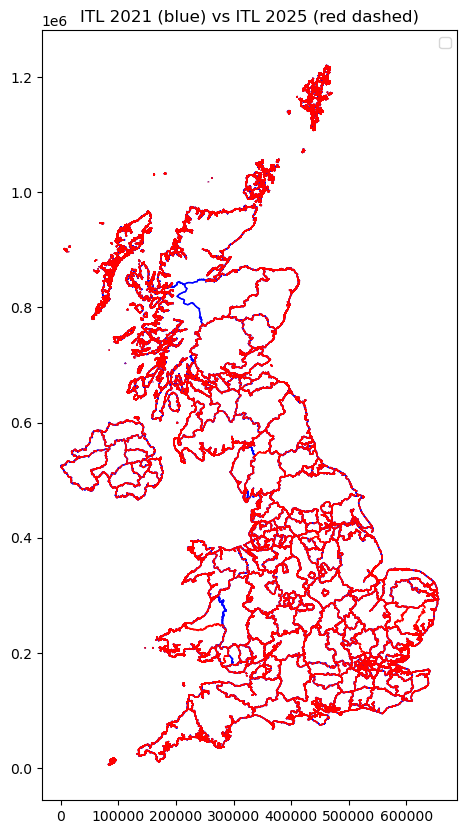

In [17]:
import matplotlib.pyplot as plt
from shapely.geometry import box

# Optional: reproject to match if needed
if itl_2021.crs != itl_2025.crs:
    itl_2025 = itl_2025.to_crs(itl_2021.crs)

# Plot both shapefiles
fig, ax = plt.subplots(figsize=(10, 10))
itl_2021.plot(ax=ax, edgecolor='blue', facecolor='none', label='ITL 2021')
itl_2025.plot(ax=ax, edgecolor='red', facecolor='none', linestyle='--', label='ITL 2025')
plt.legend()
plt.title("ITL 2021 (blue) vs ITL 2025 (red dashed)")
plt.show()

In [19]:
# Generate bounding boxes
bbox_2021 = box(*itl_2021.total_bounds)
bbox_2025 = box(*itl_2025.total_bounds)

# Wrap each box in a GeoDataFrame
bbox_gdf_2021 = gpd.GeoDataFrame(geometry=[bbox_2021], crs=itl_2021.crs)
bbox_gdf_2025 = gpd.GeoDataFrame(geometry=[bbox_2025], crs=itl_2025.crs)

# Optional: print or export
print("Bounding box 2021:", bbox_2021.bounds)
print("Bounding box 2025:", bbox_2025.bounds)

Bounding box 2021: (-116.19280000030994, 5336.966000000015, 655653.8499999996, 1220301.5020000003)
Bounding box 2025: (-116.19280000031, 5336.96600000001, 655653.85, 1220301.5020000003)


In [20]:
# Optional: save to shapefiles
bbox_gdf_2021.to_file(DATA_DIR/"ITL/2021/bounding_box_ITL2021.shp")
bbox_gdf_2025.to_file(DATA_DIR/"ITL/2025/bounding_box_ITL2025.shp")